# CART Decision Tree implemented by Shixun Wu, swu264

Below is the pseudocode of my CART implementation.
The core part is the Gini-index
$$Gini =  \sum_{p=\mathcal{P',P''}}\frac{|p|}{|\mathcal{P'}| + |\mathcal{P''}|}(1 - \sum_k^K prob_{p,k}^2) ,$$
![alt text](alg_cart.png)

In [2]:
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
import pickle as pkl
import matplotlib.pyplot as plt
from collections import defaultdict
import pydotplus
import graphviz 

In [3]:
# Class of the node 
class Node:
    def __init__(self,):
        self.child = [] # child
        self.predict = None # class of this node
        self.gini = 0 # gini index of this node
        self.label = None # label use to split
        self.label_value = None # label value used to split
        self.samples = 0 # number of instances at this node

In [4]:
# Function to do the greedy split
# Loop over all features and corresponding feature values.
# Select the feature and the value of the feature minimizes the Gini value
def greedy_split_gini(x,y):
    gini = 0
    df = x.join(y)
    min_gini = 100
    label_value = None
    size_ = x.columns.shape[0]
    # Add random permutation to loop over features
    perm = np.array([i for i in range(size_)])
    perm = np.random.permutation(perm)
    
    # Loop over features
    for i in perm:
        label = x.columns[i]
        label_stat = df[label].value_counts()
        s = label_stat.sum()
        # Random choice different values of the feature i
        perm_index = np.array([j for j in range(label_stat.index.shape[0])])
        perm_index = np.random.choice(perm_index, min(10,label_stat.index.shape[0]) , replace=False)
        # Loop over the choosed values
        for j in perm_index:
            if label_stat.index.shape[0] == 2:
                key = (label_stat.index[0] + label_stat.index[1]) / 2
            else:
                key = label_stat.index[j]
            tmp = ((df[df[label] <= key])['Label']).value_counts()
            if tmp.size > 0:
                value = tmp.sum()
                p = tmp.values[0] / tmp.sum()
                gini = value / s * (1 - p ** 2 - (1-p) ** 2)
            tmp = ((df[df[label] > key])['Label']).value_counts()
            if tmp.size > 0:
                p = tmp.values[0] / tmp.sum()
                value = tmp.sum()
                gini += value / s * (1 - p ** 2 - (1-p) ** 2)
            # update the min gini if gini < min_gini
            if gini <= min_gini:
                label_ = label
                label_value = key
                min_gini = gini
    return label_, label_value, min_gini

In [5]:
# The function to build the tree
# Recursive call this function in a DFS way
# In this function:
#   0. Preprocessing to initilize the current node.
#   1. Call greedy_split_gini to find the best partition
#   2. If the weighted sum of the Gini-index of the best partition >= Gini-index at current node, 
#      then mark this node as a leaf node and return.
#   3. Else:
#          build_dfs(left_child_node)
#          build_dfs(right_child_node)
#   4. Return    
def build_dfs(x, y, parent_num_no_ob, parent_num_ob, dp):
    #   0. Preprocessing to initilize the current node.
    node = Node()
    label_ = None
    tmp = y.value_counts()
    predict_if_leaf = False
    num_no_obesity = 0
    num_obesity = 0
    for key in tmp.index:
        if key == 0.0:
            num_no_obesity = tmp.loc[key]
        else:
            num_obesity = tmp.loc[key]
    if (num_no_obesity / parent_num_no_ob) >= ( num_obesity / parent_num_ob):
        predict_if_leaf = False
    else:
        predict_if_leaf = True
    p = tmp.values[0] / tmp.sum()
    gini_if_leaf = (1 - p ** 2 - (1-p) ** 2)
    
    #   1. Call greedy_split_gini to find the best partition
    label_, label_value, min_gini = greedy_split_gini(x,y)
    node.samples = num_obesity + num_no_obesity
    
    #   2. If the weighted sum of the Gini-index of the best partition >= Gini-index at current node, 
    #      then mark this node as a leaf node and return.
    
    if gini_if_leaf <= min_gini:
        node.label = label_
        node.predict = predict_if_leaf
        node.gini = gini_if_leaf
        node.label_value = label_value
        return node
    else:
    #   3. Else:
    #       build_dfs(left_child_node)
    #       build_dfs(right_child_node)
        node.label = label_
        node.predict = None
        node.gini = gini_if_leaf
        node.label_value = label_value
        # build left child node
        index = x.index[x[label_] <= label_value]
        child_node = build_dfs(x.loc[index], y.loc[index], num_no_obesity, num_obesity, dp+1)
        node.child.append(child_node)
        # build right child node 
        index = x.index[x[label_] > label_value]
        child_node = build_dfs(x.loc[index], y.loc[index], num_no_obesity, num_obesity, dp+1)
        node.child.append(child_node)
    #   4. Return  
    return node

In [6]:
# Function to read the data and perform preprocessing
# Map frequency adverb to integer
# Round up float into classes of integer
def preprocessing(if_sklearn=True) -> pd.DataFrame:
    df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
    # df = df.loc[:10 * b]
    df['Label'] = df['NObeyesdad'].str.startswith('Obesity').astype(int)
    del df['NObeyesdad']
    del df['Height']
    del df['Weight']

    freq_map = {'no': 0, 'Sometimes': 1,
    'Frequently': 2, 'Always': 3}
    yes_no_map = {'yes': 1, 'no': 0}
    df['Age'] = (df['Age']).round()
    df['NCP'] = (df['NCP'] * 10).round()
    df['CH2O'] = (df['CH2O'] * 10).round() #/ 10
    df['FAF'] = (df['FAF'] * 10).round() #/ 10
    df['TUE'] = (df['TUE'] * 10).round() #/ 10
    df['FCVC'] = (df['FCVC'] * 10).round() #/ 10
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
    df['family_history_with_overweight'] = df['family_history_with_overweight'].map(yes_no_map)
    df['FAVC'] = df['FAVC'].map(yes_no_map)
    df['CAEC'] = df['CAEC'].map(freq_map)
    df['SMOKE'] = df['SMOKE'].map(yes_no_map)
    df['SCC'] = df['SCC'].map(yes_no_map)
    df['CALC'] = df['CALC'].map(freq_map)
    
    df['MTRANS'] = df['MTRANS'].map({'Automobile': 0, 'Motorbike': 0, 'Public_Transportation': 0, 'Walking': 1, 'Bike': 1})
    normalized_df = (df-df.min())/(df.max()-df.min())
    df = normalized_df
    return df

In [7]:
# Function to visualize the tree
# Change my class node and the decision tree into "dot language"
def dotgraph(decisionTree):
    global dcHeadings
    dcNodes = defaultdict(list)
    """Plots the obtained decision tree. """

    def toString(iSplit, decisionTree, bBranch, szParent="null", indent=''):
        if decisionTree.predict != None:  # leaf node
            lsY = []
            
            lsY.append(f'result:{decisionTree.predict}')
            dcY = {"name": "%s" % ', '.join(lsY), "parent": szParent}
            
            dcNodes[iSplit].append(['leaf', dcY['name'], szParent, bBranch, f"{decisionTree.gini:.3f}",
                                    decisionTree.samples])
            return dcY
        else:
            szCol = decisionTree.label
            
            decision = f"{szCol} less than {decisionTree.label_value:.3f}"
            
            trueBranch = toString(iSplit + 1, decisionTree.child[0], True, decision, indent + '\t\t')
            falseBranch = toString(iSplit + 1, decisionTree.child[1], False, decision, indent + '\t\t')
            
            dcNodes[iSplit].append([iSplit + 1, decision, szParent, bBranch, f"{decisionTree.gini:.3f}",
                                    decisionTree.samples])
            return

    toString(0, decisionTree, None)
    lsDot = ['digraph Tree {',
             'node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;',
             'edge [fontname=helvetica] ;'
             ]
    i_node = 0
    dcParent = {}
    for nSplit in range(len(dcNodes)):
        lsY=dcNodes[nSplit]
        for lsX in lsY:
            iSplit, decision, szParent, bBranch, szImpurity, szSamples = lsX
            if type(iSplit) == int:
                szSplit = '%d-%s' % (iSplit, decision)
                dcParent[szSplit] = i_node
                lsDot.append('%d [label=<%s<br/>impurity %s<br/>samples %s>, fillcolor="#e5813900"] ;' % (i_node,
                                                                                                          decision.replace(
                                                                                                              '>=',
                                                                                                              '&ge;').replace(
                                                                                                              '?', ''),
                                                                                                          szImpurity,
                                                                                                          szSamples))
            else:
                lsDot.append('%d [label=<impurity %s<br/>samples %s<br/>class %s>, fillcolor="#e5813900"] ;' % (i_node,
                                                                                                                szImpurity,
                                                                                                                szSamples,
                                                                                                                decision))

            if szParent != 'null':
                if bBranch:
                    szAngle = '45'
                    szHeadLabel = 'True'
                else:
                    szAngle = '-45'
                    szHeadLabel = 'False'
                szSplit = '%d-%s' % (nSplit, szParent)
                p_node = dcParent[szSplit]
                if nSplit == 1:
                    lsDot.append('%d -> %d [labeldistance=2.5, labelangle=%s, headlabel="%s"] ;' % (p_node,
                                                                                                    i_node, szAngle,
                                                                                                    szHeadLabel))
                else:
                    lsDot.append('%d -> %d ;' % (p_node, i_node))
            i_node += 1
    lsDot.append('}')
    dot_data = '\n'.join(lsDot)
    return dot_data

sklearn result: {'accuracy': 0.9150943396226415, 'precision': 0.9, 'recall': 0.9183673469387755, 'f1': 0.9090909090909091, 'confusion': array([[104,  10],
       [  8,  90]], dtype=int64)}
result: {'accuracy': 0.8867924528301887, 'precision': 0.8854166666666666, 'recall': 0.8673469387755102, 'f1': 0.8762886597938144, 'confusion': array([[103,  11],
       [ 13,  85]], dtype=int64)}
sklearn result: {'accuracy': 0.8720379146919431, 'precision': 0.8431372549019608, 'recall': 0.8865979381443299, 'f1': 0.864321608040201, 'confusion': array([[98, 16],
       [11, 86]], dtype=int64)}
result: {'accuracy': 0.909952606635071, 'precision': 0.875, 'recall': 0.9381443298969072, 'f1': 0.9054726368159204, 'confusion': array([[101,  13],
       [  6,  91]], dtype=int64)}
sklearn result: {'accuracy': 0.8483412322274881, 'precision': 0.8421052631578947, 'recall': 0.8247422680412371, 'f1': 0.8333333333333333, 'confusion': array([[99, 15],
       [17, 80]], dtype=int64)}
result: {'accuracy': 0.90995260663

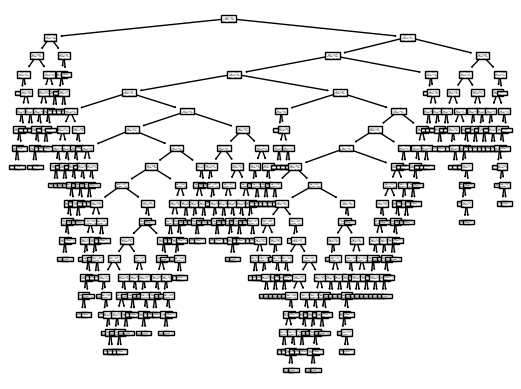

In [8]:
# Call preprocessing to read the data 
df = preprocessing()
X = df.drop(columns=['Label'])
y = df['Label']

cnt = 0
sklearn_result = []
result = []
k = 0

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=0)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # if k == 0:
    node = build_dfs(X_train, y_train, 1, 1, 1)
    dot_data = dotgraph(node)
    
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_pdf("my_CART.pdf")
    
    k += 1
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    tree.plot_tree(clf)
    dot_data = tree.export_graphviz(clf, feature_names=X_train.columns,  
                            class_names=["Healthy", "Obesity"],out_file=None) 
    graph = graphviz.Source(dot_data) 
    graph.render("sklearn_CART") 
    
    y_pred_sklearn = clf.predict(X_test)
    
    sklearn_result.append({"accuracy":accuracy_score(y_test, y_pred_sklearn),
                        "precision":precision_score(y_test, y_pred_sklearn),
                        "recall":recall_score(y_test, y_pred_sklearn),
                        "f1":f1_score(y_test, y_pred_sklearn),
                        "confusion":confusion_matrix(y_test, y_pred_sklearn)})
    print("sklearn result:", sklearn_result[-1])
    
    y_pred = np.zeros(y_pred_sklearn.shape[0])
    
    for i in range(X_test.shape[0]):
        node_ = node
        while (len(node_.child) > 0):
            if len(node_.child) > 0:
                if (X_test.iloc[i])[node_.label] <= node_.label_value:
                    node_ = node_.child[0]
                else:
                    node_ = node_.child[1]      
        if node_.predict == False and y_test.iloc[i] == 0.0:
            cnt += 1
        if node_.predict == True and y_test.iloc[i] != 0.0:
            cnt += 1
        y_pred[i] = int(node_.predict)
    result.append({"accuracy":accuracy_score(y_test, y_pred),
                        "precision":precision_score(y_test, y_pred),
                        "recall":recall_score(y_test, y_pred),
                        "f1":f1_score(y_test, y_pred),
                        "confusion":confusion_matrix(y_test, y_pred)})
    print("result:", result[-1])
    with open("sklearn_result.pkl", "wb") as f:
        pkl.dump(sklearn_result, f)
    with open("result.pkl", "wb") as f:
        pkl.dump(result, f)